In [1]:
import pickle
from sklearn.cluster import DBSCAN
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
import mach_functions
import cv2
import os
import argparse

In [2]:
# where the binary files are:
cases = ['ram','rod','hyp','dys','amoe'] # 5 case

filedir = "/home/binsun/microglia_MACH/all_results/184" # change this to the directory where you put the binary file

In [3]:
# readin the binary image

bimage = {i:np.load(filedir+"/"+i+"binary") for i in cases}

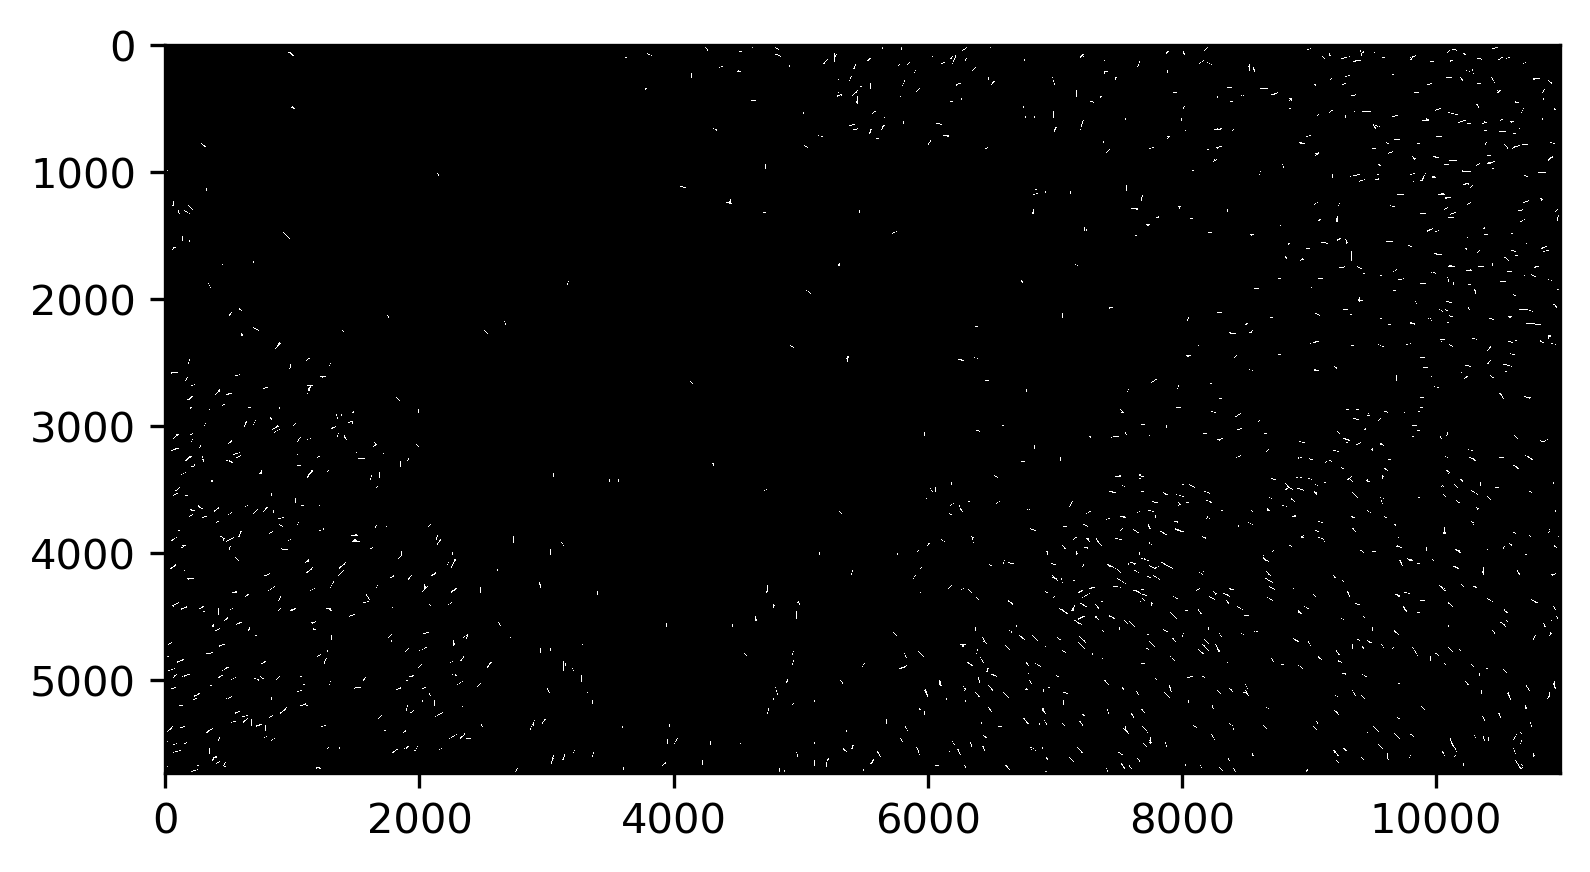

In [5]:
plt.figure(dpi=300)
plt.imshow(bimage['rod'],cmap='gray')

In [8]:
# get the centoid of each detected cells
def getCellLocations(bimage):
    """
    Get the locations of detected cells
    """
    lbl = ndimage.label(bimage)[0]
    coords = ndimage.measurements.center_of_mass(bimage, lbl,list(range(1,np.max(lbl)+1)))
    coords = np.asarray(coords)
    
    return coords
    



In [9]:
locations = {i:getCellLocations(bimage[i]) for i in cases}

In [15]:
print (locations['rod'])

[[1.30573770e+01 4.28727869e+03]
 [1.22661290e+01 4.62512903e+03]
 [9.64480874e+00 4.87057923e+03]
 ...
 [5.71710256e+03 4.87695897e+03]
 [5.71721121e+03 6.93254310e+03]
 [5.72072358e+03 1.06335854e+04]]


In [16]:
def drawLocations(location):
    """
    Draw the cells using the coords (in unit of pixels)
    """
    fig, ax = plt.subplots()
    im = ax.scatter(location[:,0], location[:,1])
    plt.gca().invert_yaxis()

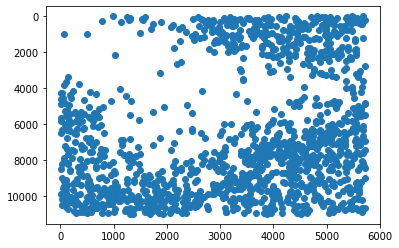

In [17]:
drawLocations(locations['rod'])